### Ollama

In [1]:
import requests

MODEL = "llama3.2:1b"
URL = "http://localhost:11434/api/chat"

In [2]:
# The following code also calls the appropriate Ollama endpoint and activates the model.

def ollama(model, prompt):
    data = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "stream": False,
    }

    headers = {
        "Content-Type": "application/json"
    }

    response = requests.post(URL, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()["message"]["content"]
    else:
        return "Error"

In [3]:
response = ollama(
    model=MODEL,
    prompt="How often does the letter a appear in banana?"
    )

print(response)

The letter "a" appears twice in the word "banana".


In [8]:
# To list all actively running models, you can use the following code:
!ollama ps

zsh:1: command not found: ollama


In [ ]:
# To stop the Ollama server, execute the following command:
!ollama stop llama3.2:1b

# Confirmation
!ollama ps

NAME    ID    SIZE    PROCESSOR    UNTIL 


### Performance

In [ ]:
from datasets import load_dataset

def load_financial_phrasebank():
    # Load the Financial PhraseBank dataset from Hugging Face
    dataset = load_dataset(path="takala/financial_phrasebank", name="sentences_50agree", trust_remote_code=True)
    
    # Print dataset details to verify successful loading
    print("Dataset splits available:", dataset.keys())
    # Print an example from the train split
    if "train" in dataset:
        print("First example from 'train' split:", dataset["train"][0])
    else:
        print("No 'train' split found. Dataset details:", dataset)

    return dataset

dataset = load_financial_phrasebank()

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset splits available: dict_keys(['train'])
First example from 'train' split: {'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}


In [13]:
label_dict = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# count the number of examples of each label in the dataset
label_counts = {label_dict[label]: sum([example["label"] == label for example in dataset["train"]]) for label in label_dict}
print("Label counts in the 'train' split:", label_counts)

# split into train and test sets using sk learn
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(dataset["train"]["sentence"], dataset["train"]["label"], test_size=0.2, random_state=42)

Label counts in the 'train' split: {'negative': 604, 'neutral': 2879, 'positive': 1363}


In [20]:
def get_prompt(text):
    return f"""
            Please classify the sentiment of the following financial text:
            {text}
            Sentiment Options: negative, neutral, positive
            Do not include any other information in your response.
            """

In [27]:
# get predictions from the Ollama model for the first 50 examples in the test set
pred_labels = []

for text in test_texts[:50]:
    print("Input text:", text)
    print("True label:", label_dict[test_labels[test_texts.index(text)]])
    predicted_label = ollama(model=MODEL, prompt=get_prompt(text))
    print("Predicted label:", predicted_label)
    print()
    # strip and lowercase the predicted label
    predicted_label = predicted_label.strip().lower()
    pred_labels.append(predicted_label)

Input text: The company was supposed to deliver machinery to a veneer mill in the Tomsk region , in Russia .
True label: neutral
Predicted label: negative

Input text: UNC Charlotte would also deploy SSH Tectia Connector to enable secure application connectivity .
True label: neutral
Predicted label: neutral

Input text: In 2009 , Lee & Man had a combined annual production capacity of close to 4.5 million tonnes of paper and 300,000 tonnes of pulp .
True label: neutral
Predicted label: neutral

Input text: `` That 's a very high figure on the European scale , '' Noop said , recalling however that this also includes beer bought by Finnish tourists .
True label: neutral
Predicted label: positive

Input text: In Finland , the corresponding service is Alma Media 's Etuovi.com , Finland 's most popular and best known nationwide online service for home and property sales .
True label: neutral
Predicted label: neutral

Input text: Construction is scheduled to start in April-June 2007 and to b

Model accuracy on the test set: 0.34


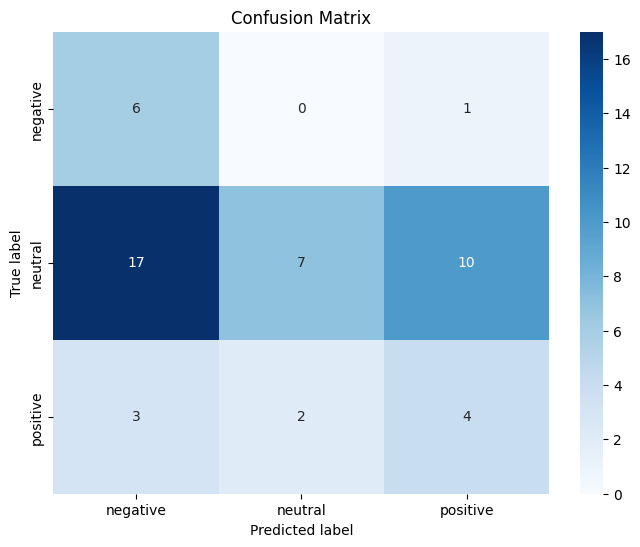

In [ ]:
# calculate the accuracy of the model on the test set and print confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix

# convert the predicted labels to numerical values
pred_labels_num = [list(label_dict.keys())[list(label_dict.values()).index(label)] for label in pred_labels]

# calculate the accuracy
accuracy = accuracy_score(test_labels[:50], pred_labels_num)
print("Model accuracy on the test set:", accuracy)

# print the confusion matrix
conf_matrix = confusion_matrix(test_labels[:50], pred_labels_num)

# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

### CodeCarbon

In [2]:
import tensorflow as tf
from codecarbon import EmissionsTracker

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
    ]
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with EmissionsTracker(
    project_name="model-distillation", 
    experiment_id="123", 
    tracking_mode="process",
    output_dir="metrics/emissions"
    ) as tracker:
    model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
    model.fit(x_train, y_train, epochs=1)

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 11:22:51] [setup] RAM Tracking...
[codecarbon INFO @ 11:22:51] [setup] CPU Tracking...
[codecarbon WARNING @ 11:22:52] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 11:22:52] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 11:22:52] [setup] GPU Tracking...
[codecarbon INFO @ 11:22:52] No GPU found.
[codecarbon INFO @ 11:22:52] >>> Tracker's metadata:
[codecarbon INFO @ 11:22:52]   Platform system: macOS-15.3-arm64-arm-64bit
[codecarbon INFO @ 11:22:52]   Python ve

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8617 - loss: 0.4690


[codecarbon INFO @ 11:22:56] Energy consumed for RAM : 0.000000 kWh. RAM Power : 0.07154273986816406 W
[codecarbon INFO @ 11:22:56] Energy consumed for all CPUs : 0.000005 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 11:22:56] 0.000005 kWh of electricity used since the beginning.


In [3]:
print(f"Tracked final energy consumption: {tracker._total_energy.kWh} kWh")
print(f"Tracked final CO2 emissions: {tracker.final_emissions} kgCO2")

Tracked final energy consumption: 5.1546787110767475e-06 kWh
Tracked final CO2 emissions: 7.817070265347888e-07 kgCO2
